In [3]:
import os
import cv2
import ray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from matplotlib import image as img
from scipy.spatial. distance import cosine, euclidean

In [4]:
PATH = "./flowers/"
flower_types = [ "bougainvillea", "daisies",  "garden_roses", "gardenias", "hibiscus", "hydrangeas", "lilies", "orchids", "peonies", "tulip" ]

In [5]:
np.unique(
    list(
        map(lambda arr: "_".join(arr[:-1]),
            map(lambda file: file.split("_"), os.listdir(PATH))
        )
    )
)

array(['bougainvillea', 'daisies', 'garden_roses', 'gardenias',
       'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip'],
      dtype='<U13')

In [6]:
def get_filename(flower_type, idx = 0):
    flowers = list(filter(lambda filename: flower_type in filename, sorted(os.listdir(PATH)) ))
    return flowers[idx]

In [7]:
def read_image(filename, width=256, height=256):
    shape = (width, height)
    return cv2.resize(
        img.imread(PATH + filename),
        shape
    )

In [8]:
def get_image(type_idx=0, idx=0):
    return read_image(
        get_filename(flower_types[type_idx], idx)
    )

# Color Histogram

In [9]:
files = os.listdir("flowers/")

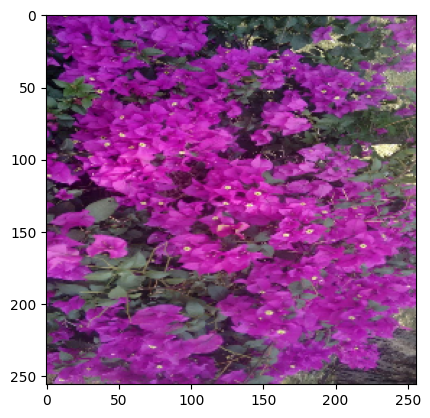

In [10]:
plt.imshow(get_image(0,0))

## RGB

In [11]:
ray.init()

2023-04-06 18:35:29,508	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.2.0


In [12]:
@ray.remote
def get_histogram(i, file):
    if i%50==0:
        print(i)
    
    x = []
    temp = read_image(file)
    for channel in range(3):
        bin_counts, _ = np.histogram(
                temp[:,:,channel].ravel(),
                bins=8,
                range=(0,255)
        )
        
        x = np.hstack((x, bin_counts))

    return x.reshape(-1,1).T

def get_hist_feat(files):
    X = np.empty((0, 8*3))
    
    res = []
    for i, file in enumerate(files):
        res.append( get_histogram.remote(i, file) )
    data = ray.get(res)

    print("Processing Finished.\nAppending data...")
    
    for x in data:
        X = np.concatenate((X, x), axis=0)
    return X

In [13]:
features = get_hist_feat(files)

(get_histogram pid=41812) 0
(get_histogram pid=23712) 50
(get_histogram pid=41812) 100
(get_histogram pid=66988) 150
(get_histogram pid=41080) 200
(get_histogram pid=41812) 250
(get_histogram pid=66988) 300
(get_histogram pid=41812) 350
(get_histogram pid=41080) 400
(get_histogram pid=66988) 450
(get_histogram pid=66988) 500
(get_histogram pid=41080) 550
(get_histogram pid=23712) 600
(get_histogram pid=41080) 650
(get_histogram pid=41080) 700
Processing Finished.
Appending data...


In [14]:
for i in range(features.shape[0]):
    features[i] = features[i] / features[i].sum()

In [20]:
k=10
print(files[k])
results = np.argsort([
    euclidean(
        features[k],
        features[i]
    ) for i in range(features.shape[0])
])[:15]
results

bougainvillea_00013.jpg


array([ 10, 214, 181,  23, 179,   9,   7, 193, 213,  53, 173,  34,  47,
        27,  40], dtype=int64)

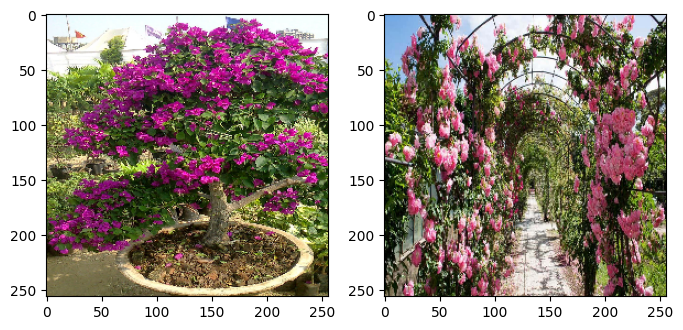

In [21]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_image(files[k]))
ax[1].imshow(read_image(files[results[1]]))

## Grayscale

In [24]:
@ray.remote
def get_gray_histogram(i, file):
    if i%50==0:
        print(i)
    
    temp = read_image(file)
    x = np.histogram(
        temp.mean(axis=2).ravel(),
        bins=8,
        range=(0,255)
    )[0]
    x=x/x.sum()

    return x.reshape(-1,1).T

def get_gray_hist_feat(files):
    X = np.empty((0, 8))
    
    res = []
    for i, file in enumerate(files):
        res.append( get_gray_histogram.remote(i, file) )
    data = ray.get(res)

    print("Processing Finished.\nAppending data...")
    
    for x in data:
        X = np.concatenate((X, x), axis=0)
    return X
    

In [25]:
features = get_gray_hist_feat(files)

(get_gray_histogram pid=41080) 0
(get_gray_histogram pid=41080) 50
(get_gray_histogram pid=23712) 100
(get_gray_histogram pid=41812) 150
(get_gray_histogram pid=66988) 200
(get_gray_histogram pid=41080) 250
(get_gray_histogram pid=23712) 300
(get_gray_histogram pid=41080) 350
(get_gray_histogram pid=23712) 400
(get_gray_histogram pid=66988) 450
(get_gray_histogram pid=66988) 500
(get_gray_histogram pid=41812) 550
(get_gray_histogram pid=66988) 600
(get_gray_histogram pid=66988) 650
(get_gray_histogram pid=23712) 700
Processing Finished.
Appending data...


In [26]:
features[0].sum()

1.0

In [28]:
k=0
print(files[k])
nresults = np.argsort([
    euclidean(
        features[k],
        features[i]
    ) for i in range(features.shape[0])
])[:15]
results

bougainvillea_00002.jpg


array([ 10, 214, 181,  23, 179,   9,   7, 193, 213,  53, 173,  34,  47,
        27,  40], dtype=int64)

In [29]:
np.random.choice(list(range(len(files))), size=15, replace=False)

array([669, 681, 147,  69, 595, 582,  57, 624, 575, 498, 525, 170, 393,
       492, 366])

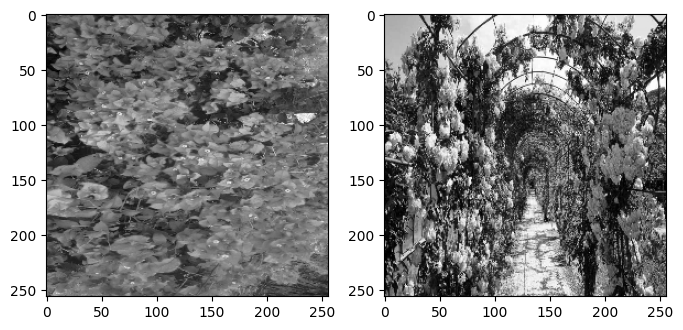

In [32]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(
    read_image(
        files[k]
    ).mean(axis=2), cmap="gray"
)
ax[1].imshow(
    read_image(
        files[results[1]]
    ).mean(axis=2), cmap="gray"
)


In [43]:
ray.shutdown()

Although the top15 elements seem to have better performance than random chance, color features do not seem to be good features to distinguish the different flowers

# Histogram color moments

In [ ]:
ray.init()

In [33]:
features = get_hist_feat(files)

(get_histogram pid=23712) 0
(get_histogram pid=41812) 50
(get_histogram pid=41812) 100
(get_histogram pid=66988) 150
(get_histogram pid=66988) 200
(get_histogram pid=41812) 250
(get_histogram pid=41080) 300
(get_histogram pid=41812) 350
(get_histogram pid=41080) 400
(get_histogram pid=23712) 450
(get_histogram pid=23712) 500
(get_histogram pid=23712) 550
(get_histogram pid=23712) 600
(get_histogram pid=41080) 650
(get_histogram pid=41812) 700
Processing Finished.
Appending data...


In [34]:
def get_color_moments(histograms):
    features = []
    for hist in histograms:
        mean = hist.mean()
        std = hist.std()
        sk = ss.skew(hist)
        kurt = ss.kurtosis(hist)
        
        features.append([mean, std, sk, kurt])
    return np.array(features)

In [35]:
features = get_color_moments(features)

In [44]:
k=90
print(files[k])
results = np.argsort([
    euclidean(
        features[k],
        features[i]
    ) for i in range(features.shape[0])
])[:15]
results

daisies_00018.jpg


array([ 90, 206, 451, 241, 295,   2, 112, 249, 526, 728,  82, 578, 708,
       458, 545], dtype=int64)

garden_roses_00060.jpg


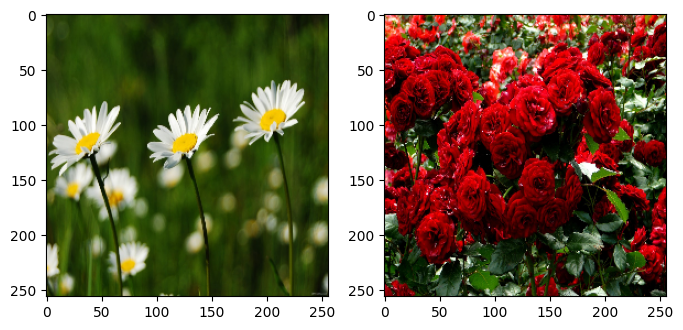

2023-04-06 18:43:19,888	ERROR import_thread.py:75 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:62895 {grpc_message:"Stream removed", grpc_status:2, created_time:"2023-04-06T17:43:19.857203395+00:00"}"
>
Exception in thread ray_listen_error_messages:
Traceback (most recent call last):
  File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
2023-04-06 18:43:19,906	ERROR worker.py:813 -- print_logs: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:62895 {grpc_message:"Stream removed", grpc_status:2, created_time:"2023-04-06T17:43:19.857221299+00:00"}"
>
    self.run()
  File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\threading.py", lin

In [45]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_image(files[k]))
print(files[results[1]])
ax[1].imshow(read_image(files[results[1]]))